# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           plot_parameter_sensitivity,
                           plot_parameters_kde)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [6]:
from channels.ikur import ikur as model
#model.sample({})

# Get experimental measurements

In [7]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [8]:
limits = dict(g_Kur=(0, 1),
              k_ass1=(0, 100),
              k_ass2=(0, 100),
              k_atau1=(0, 100),
              k_atau2=(0, 100),
              k_atau3=(0, 10),
              k_iss1=(0, 100),
              k_iss2=(0, 100),
              k_itau1=(0, 10),
              k_itau2=(0, 100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [9]:
parameters = ['ikur.'+k for k in limits.keys()]

In [10]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

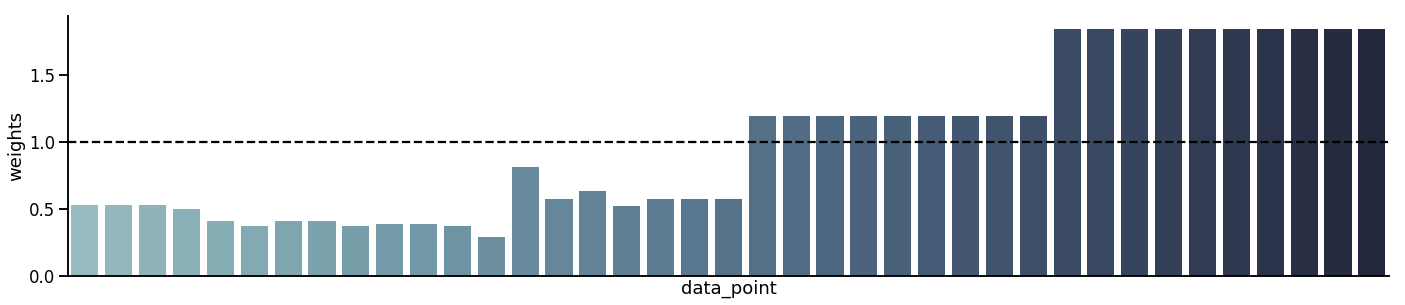

In [11]:
from ionchannelABC import plot_distance_weights
sns.set_context('talk')
grid = plot_distance_weights(model, distance_fn)
grid.savefig('results/ikur/dist_weights.pdf')

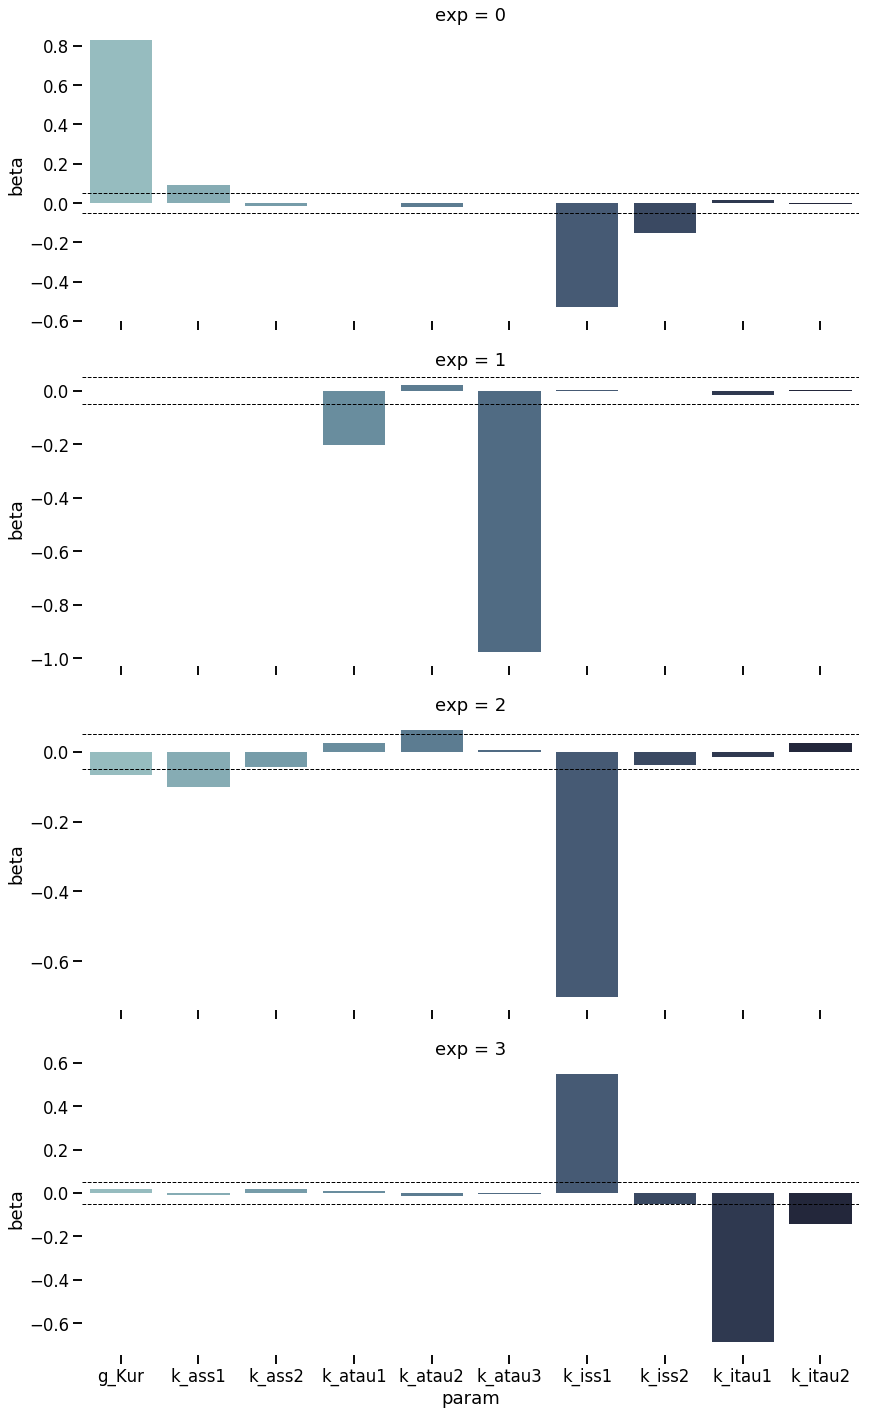

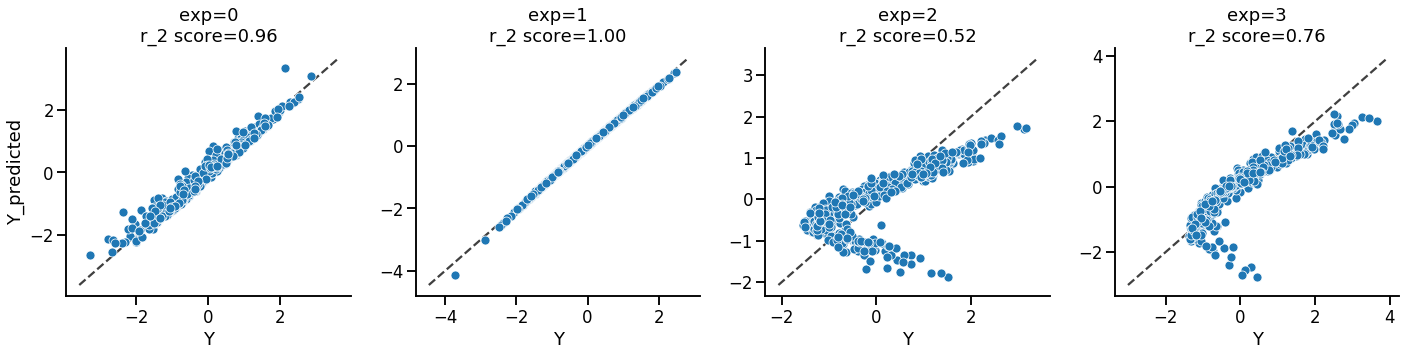

In [14]:
grid1, grid2 = plot_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=500,
    plot_cutoff=0.05)

In [15]:
grid1.savefig('results/ikur/sensitivity.pdf')
grid2.savefig('results/ikur/sensitivity_fit.pdf')

# Initialise pyabc database

In [16]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ikur.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ikur.db


In [17]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [18]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=2000,
                 mean_cv=0.4,
                 max_population_size=5000,
                 min_population_size=1000),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.5258873292334321, 1: 0.5258873292334321, 2: 0.5258873292334321, 3: 0.4995929627717598, 4: 0.4114294987532165, 5: 0.3681211304634045, 6: 0.4114294987532165, 7: 0.4114294987532165, 8: 0.3681211304634025, 9: 0.3885723043780368, 10: 0.3885723043780368, 11: 0.3681211304634025, 12: 0.29142922828352713, 13: 0.8154291198404024, 14: 0.5708773676507556, 15: 0.634507863567063, 16: 0.5192914070433957, 17: 0.5708773676507556, 18: 0.5706977711634583, 19: 0.5712368999490637, 20: 1.1938458383673252, 21: 1.1938458383673252, 22: 1.1938458383673252, 23: 1.1938458383673252, 24: 1.1938458383673252, 25: 1.1938458383673252, 26: 1.1938458383673252, 27: 1.1938458383673252, 28: 1.1938458383673252, 29: 1.8517988982667652, 30: 1.8517988982667652, 31: 1.8517988982667652, 32: 1.8517988982667652, 33: 1.8517988982667652, 34: 1.8517988982667652, 35: 1.8517988982667652, 36: 1.8517988982667652, 37: 1.8517988982667652, 38: 1.8517988982667652}
DEBUG:Epsilon:init quantile_epsilon initia

In [19]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-09-11 16:38:22.725490, end_time=None)>
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
INFO:Epsilon:initial epsilon is 55.02087685530802


In [ ]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=10, min_acceptance_rate=0.01)

INFO:ABC:t:20 eps:2.1918147381072175
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/smc.py:735: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()


# Results analysis

In [8]:
db_path = ('sqlite:///results/ikur/hl-1_ikur.db')
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-08-22 21:17:04.358667, end_time=2018-08-23 04:15:04.475650)>,
 <ABCSMC(id=2, start_time=2018-08-23 09:41:52.614281, end_time=2018-08-25 04:05:31.777520)>]

In [9]:
history.id = 2

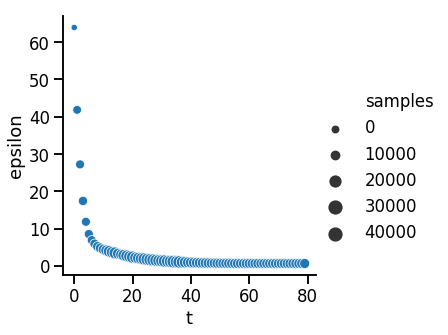

In [19]:
sns.set_context('talk')
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
grid.savefig('results/iha/eps_evolution.pdf')

In [20]:
df, w = history.get_distribution(m=0)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()


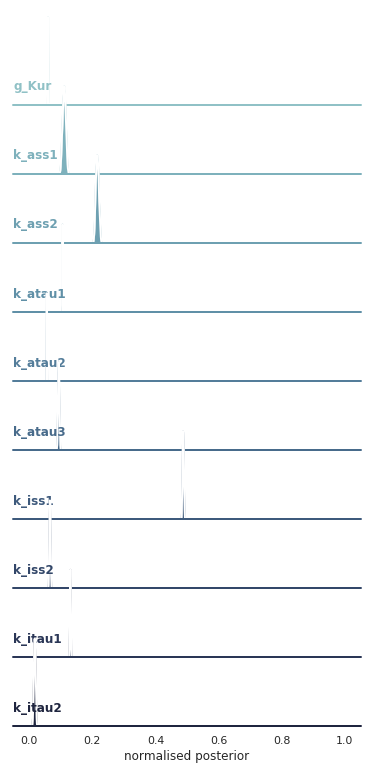

In [21]:
g = plot_parameters_kde(df, w, limits, aspect=5, height=1.1)

In [22]:
g.savefig('results/ikur/parameters_kde.pdf')

# Samples for quantitative analysis

In [10]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [11]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


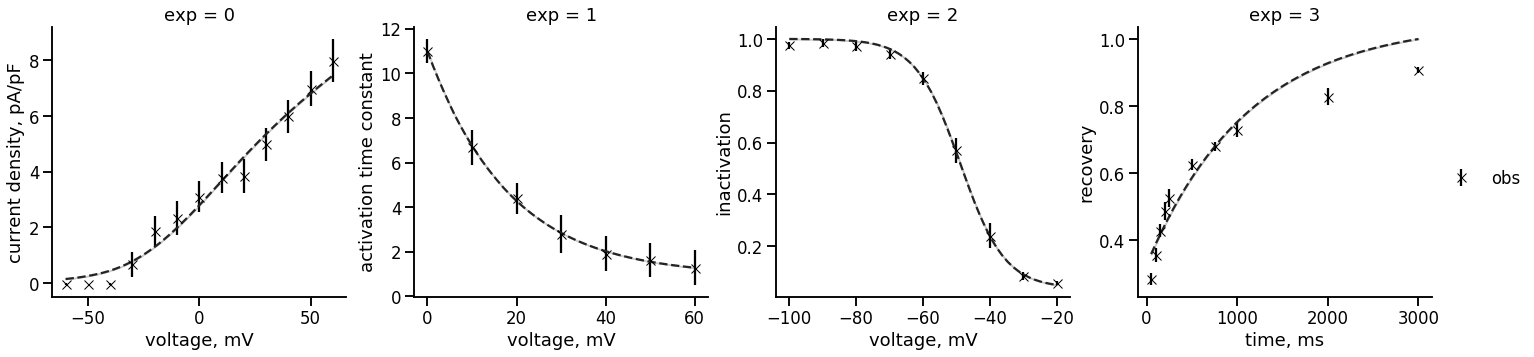

In [12]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms"]
ylabels = ["current density, pA/pF", "activation time constant", "inactivation", "recovery"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [13]:
g.savefig('results/ikur/ikur_sim_results.pdf')

In [14]:
# Get rid of infinite values
pd.options.mode.use_inf_as_na = True
print(samples.isna().sum())
samples = samples.dropna()

x               0
y               0
exp             0
sample          0
distribution    0
dtype: int64


In [15]:
# Activation kinetics measurements from Xu
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_single_exp(group):
    def single_exp(V, a, b, c):
        return a + b*(np.exp(-V/c))
    guess = (10, 5, 10)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_single_exp).apply(pd.Series)

In [16]:
print(output.mean())
print(output.std())

0     0.896580
1    10.121804
2    18.270029
dtype: float64
0    0.019703
1    0.021651
2    0.106880
dtype: float64


In [17]:
import scipy.stats as st
a = output[0].tolist()
rv = st.rv_discrete(values=(a, [1/len(a),]*len(a)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 0.8953437535131284
95% CI: (0.8633541995337374, 0.9401214979469593)


In [20]:
b = output[1].tolist()
rv = st.rv_discrete(values=(b, [1/len(b),]*len(b)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 10.123657575028155
95% CI: (10.07974275651743, 10.159405337369998)


In [21]:
c = output[2].tolist()
rv = st.rv_discrete(values=(c, [1/len(c),]*len(c)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 18.271857683000704
95% CI: (18.05947963733289, 18.445100873172496)


In [22]:
# Parameters of Boltzmann fit to inactivation
grouped = samples[samples.exp==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((V-Vhalf)/Shalf))
    guess = (50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [23]:
print(output.mean())
print(output.std())

0   -48.028217
1     7.220269
dtype: float64
0    0.203923
1    0.180868
dtype: float64


In [24]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -48.04332517012564
95% CI: (-48.40092953563154, -47.65196941300511)


In [25]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 7.215884725611901
95% CI: (6.871906149052206, 7.539045993338593)


In [26]:
# Recovery dynamics from Brouillette
grouped = samples[samples.exp==3].groupby('sample')
def fit_single_exp(group):
    def single_exp(V, a, b, c):
        return a + b*(np.exp(-V/c))
    guess = (1, -1, 300)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_single_exp).apply(pd.Series)

In [27]:
print(output.mean())
print(output.std())

0       1.050677
1      -0.722907
2    1128.436579
dtype: float64
0     0.003545
1     0.003028
2    29.252220
dtype: float64


In [28]:
tau = output[2].tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 1127.9882082283295
95% CI: (1069.8835047509497, 1182.5716080613363)
